## Identifiability Test of Linear VAE on Synthetic Dataset

In [3]:
%load_ext autoreload
%autoreload 2

In [11]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import ltcl
import numpy as np
from ltcl.datasets.sim_dataset import SimulationDatasetTSTwoSample
from ltcl.modules.srnn import SRNNSynthetic
from ltcl.tools.utils import load_yaml
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
use_cuda = True
device = torch.device("cuda:0" if use_cuda else "cpu")
latent_size = 8

In [8]:
data = SimulationDatasetTSTwoSample(directory = '/srv/data/ltcl/data/', 
                                    transition='linear_nongaussian_ts')
num_validation_samples = 2500
train_data, val_data = random_split(data, [len(data)-num_validation_samples, num_validation_samples])
train_loader = DataLoader(train_data, batch_size=12800, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_data, batch_size=16, shuffle=False, pin_memory=True)

In [14]:
cfg = load_yaml('../ltcl/configs/toy_linear_ts.yaml')

In [123]:
model =  SRNNSynthetic.load_from_checkpoint(checkpoint_path="/srv/data/ltcl/log/weiran/toy_linear_ts/lightning_logs/version_1/checkpoints/epoch=299-step=228599.ckpt",
                                            input_dim=cfg['VAE']['INPUT_DIM'],
                                            length=cfg['VAE']['LENGTH'],
                                            z_dim=cfg['VAE']['LATENT_DIM'], 
                                            lag=cfg['VAE']['LAG'],
                                            hidden_dim=cfg['VAE']['ENC']['HIDDEN_DIM'],
                                            trans_prior=cfg['VAE']['TRANS_PRIOR'],
                                            bound=cfg['SPLINE']['BOUND'],
                                            count_bins=cfg['SPLINE']['BINS'],
                                            order=cfg['SPLINE']['ORDER'],
                                            beta=cfg['VAE']['BETA'],
                                            gamma=cfg['VAE']['GAMMA'],
                                            sigma=cfg['VAE']['SIGMA'],
                                            lr=cfg['VAE']['LR'],
                                            bias=cfg['VAE']['BIAS'],
                                            use_warm_start=cfg['SPLINE']['USE_WARM_START'],
                                            spline_pth=cfg['SPLINE']['PATH'],
                                            decoder_dist=cfg['VAE']['DEC']['DIST'],
                                            correlation=cfg['MCC']['CORR'])

Load pretrained spline flow


### Load model checkpoint

In [124]:
model.eval()

SRNNSynthetic(
  (enc): MLPEncoder(
    (net): NLayerLeakyMLP(
      (net): Sequential(
        (0): Linear(in_features=8, out_features=128, bias=True)
        (1): LeakyReLU(negative_slope=0.2)
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): LeakyReLU(negative_slope=0.2)
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): LeakyReLU(negative_slope=0.2)
        (6): Linear(in_features=128, out_features=128, bias=True)
        (7): LeakyReLU(negative_slope=0.2)
        (8): Linear(in_features=128, out_features=8, bias=True)
      )
    )
  )
  (dec): MLPDecoder(
    (net): NLayerLeakyMLP(
      (net): Sequential(
        (0): Linear(in_features=8, out_features=128, bias=True)
        (1): LeakyReLU(negative_slope=0.2)
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): LeakyReLU(negative_slope=0.2)
        (4): Linear(in_features=128, out_features=8, bias=True)
      )
    )
  )
  (rnn): GRU(8, 128, batc

In [125]:
model.to('cpu')

SRNNSynthetic(
  (enc): MLPEncoder(
    (net): NLayerLeakyMLP(
      (net): Sequential(
        (0): Linear(in_features=8, out_features=128, bias=True)
        (1): LeakyReLU(negative_slope=0.2)
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): LeakyReLU(negative_slope=0.2)
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): LeakyReLU(negative_slope=0.2)
        (6): Linear(in_features=128, out_features=128, bias=True)
        (7): LeakyReLU(negative_slope=0.2)
        (8): Linear(in_features=128, out_features=8, bias=True)
      )
    )
  )
  (dec): MLPDecoder(
    (net): NLayerLeakyMLP(
      (net): Sequential(
        (0): Linear(in_features=8, out_features=128, bias=True)
        (1): LeakyReLU(negative_slope=0.2)
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): LeakyReLU(negative_slope=0.2)
        (4): Linear(in_features=128, out_features=8, bias=True)
      )
    )
  )
  (rnn): GRU(8, 128, batc

### Compute permutation and sign flip

In [126]:
for batch in train_loader:
    break

In [127]:
batch_size = batch['s1']['xt'].shape[0]

In [178]:
zs.shape

torch.Size([12800, 6, 8])

In [189]:
zs, mu, logvar = model.forward(batch['s1'])
mu = mu.view(batch_size, -1, latent_size)
A = mu[:,0,:].detach().cpu().numpy()
B = batch['s1']['yt'][:,0,:].detach().cpu().numpy()
C = np.zeros((latent_size,latent_size))
for i in range(latent_size):
    C[i] = -np.abs(np.corrcoef(B, A, rowvar=False)[i,latent_size:])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(C)
A = A[:, col_ind]
mask = np.ones(latent_size)
for i in range(latent_size):
    if np.corrcoef(B, A, rowvar=False)[i,latent_size:][i] > 0:
        mask[i] = -1
print("Permutation:",col_ind)
print("Sign Flip:", mask)

Permutation: [2 0 1 6 7 3 4 5]
Sign Flip: [-1.  1. -1. -1.  1. -1. -1. -1.]


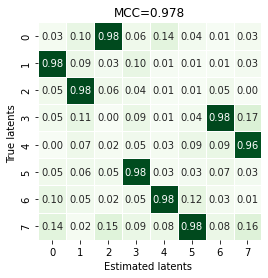

In [190]:
fig = plt.figure(figsize=(4,4))
sns.heatmap(-C, vmin=0, vmax=1, annot=True, fmt=".2f", linewidths=.5, cbar=False, cmap='Greens')
plt.xlabel("Estimated latents ") 
plt.ylabel("True latents ") 
plt.title("MCC=%.3f"%np.abs(C[row_ind, col_ind]).mean());

In [185]:
figure_path = '/home/weiran/figs/'

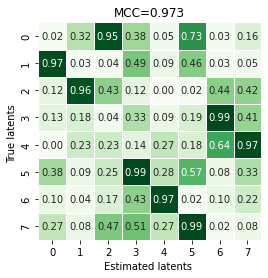

In [188]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages(figure_path + '/mcc_var.pdf') as pdf:

    fig = plt.figure(figsize=(4,4))
    sns.heatmap(-C, vmin=0, vmax=1, annot=True, fmt=".2f", linewidths=.5, cbar=False, cmap='Greens')
    plt.xlabel("Estimated latents ") 
    plt.ylabel("True latents ") 
    plt.title("MCC=%.3f"%np.abs(C[row_ind, col_ind]).mean());
    pdf.savefig(fig, bbox_inches="tight")

In [14]:
# Permute column here
mu = mu[:,:,col_ind]
# Flip sign here
mu = mu * torch.Tensor(mask, device=mu.device).view(1,1,latent_size)
mu = -mu

Text(0.5, 1.0, 'Current latent variable $z_t$')

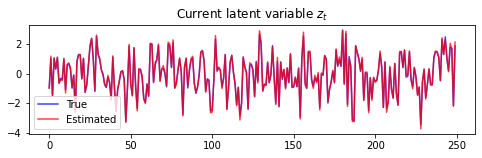

In [15]:
fig = plt.figure(figsize=(8,2))
col = 0
plt.plot(mu[:250,-1,col].detach().cpu().numpy(), color='b', label='True', alpha=0.75)
plt.plot(batch['yt_'].squeeze()[:250,col].detach().cpu().numpy(), color='r', label="Estimated", alpha=0.75)
plt.legend()
plt.title("Current latent variable $z_t$")

Text(0.5, 1.0, 'Past latent variable $z_l$')

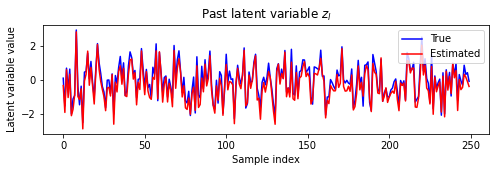

In [16]:
fig = plt.figure(figsize=(8,2))
col = 3
l = 1
plt.plot(batch['yt'].squeeze()[:250,l,col].detach().cpu().numpy(), color='b', label='True')
plt.plot(mu[:,:-1,:][:250,l,col].detach().cpu().numpy(), color='r', label="Estimated")
plt.xlabel("Sample index")
plt.ylabel("Latent variable value")
plt.legend()
plt.title("Past latent variable $z_l$")

/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Learned noise prior')

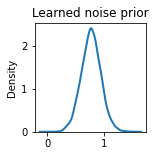

In [22]:
fig = plt.figure(figsize=(2,2))
eps = model.sample(batch["xt"].cpu())
eps = eps.detach().cpu().numpy()
component_idx = 4
sns.distplot(eps[:,component_idx], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2});
plt.title("Learned noise prior")

### System identification (causal discovery)

In [104]:
from ltcl.modules.components.base import GroupLinearLayer
trans_func = GroupLinearLayer(din = 8, 
                              dout = 8,
                              num_blocks = 2,
                              diagonal = False)
b = torch.nn.Parameter(0.001 * torch.randn(1, 8))
opt = torch.optim.Adam(trans_func.parameters(),lr=0.01)
lossfunc = torch.nn.L1Loss()

In [105]:
max_iters = 2
counter = 0
for step in range(max_iters):
    for batch in train_loader:
        batch_size = batch['yt'].shape[0]
        x_recon, mu, logvar, z = model.forward(batch)
        mu = mu.view(batch_size, -1, 8)
        # Fix permutation before training
        mu = mu[:,:,col_ind]
        # Fix sign flip before training
        mu = mu * torch.Tensor(mask, device=mu.device).view(1,1,8)
        mu = -mu
        pred = trans_func(mu[:,:-1,:]).sum(dim=1) + b
        true = mu[:,-1,:]
        loss = lossfunc(pred, true) #+ torch.mean(adaptive.lossfun((pred - true)))

        opt.zero_grad()
        loss.backward()
        opt.step()
        if counter % 100 == 0:
            print(loss.item())
        counter += 1

1.0767319202423096
0.213593527674675


### Visualize causal matrix

In [129]:
B2 = model.transition_prior.transition.w[0][col_ind][:, col_ind].detach().cpu().numpy()
B1 = model.transition_prior.transition.w[1][col_ind][:, col_ind].detach().cpu().numpy()
B1 = B1 * mask.reshape(1,-1) * (mask).reshape(-1,1)
B2 = B2 * mask.reshape(1,-1) * (mask).reshape(-1,1)

In [130]:
BB2 = np.load("/srv/data/ltcl/data/linear_nongaussian_ts/W2.npy")
BB1 = np.load("/srv/data/ltcl/data/linear_nongaussian_ts/W1.npy")

In [131]:
# b = np.concatenate((B1,B2), axis=0)
# bb = np.concatenate((BB1,BB2), axis=0)
# b = b / np.linalg.norm(b, axis=0).reshape(1, -1)
# bb = bb / np.linalg.norm(bb, axis=0).reshape(1, -1)
# pred = (b / np.linalg.norm(b, axis=0).reshape(1, -1)).reshape(-1)
# true = (bb / np.linalg.norm(bb, axis=0).reshape(1, -1)).reshape(-1)

In [152]:
bs = [B1, B2]
bbs = [BB1, BB2]

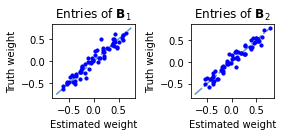

In [174]:
with PdfPages(figure_path + '/entries.pdf') as pdf:
    fig, axs = plt.subplots(1,2, figsize=(4,2))
    for tau in range(2):
        ax = axs[tau]
        b = bs[tau]
        bb = bbs[tau]
        b = b / np.linalg.norm(b, axis=0).reshape(1, -1)
        bb = bb / np.linalg.norm(bb, axis=0).reshape(1, -1)
        pred = (b / np.linalg.norm(b, axis=0).reshape(1, -1)).reshape(-1)
        true = (bb / np.linalg.norm(bb, axis=0).reshape(1, -1)).reshape(-1)
        ax.scatter(pred, true, s=10, cmap=plt.cm.coolwarm, zorder=10, color='b')
        lims = [-0.75,0.75
        ]

        # now plot both limits against eachother
        ax.plot(lims, lims, '-.', alpha=0.75, zorder=0)
        # ax.set_xlim(lims)
        # ax.set_ylim(lims)
        ax.set_xlabel("Estimated weight")
        ax.set_ylabel("Truth weight")
        ax.set_title(r"Entries of $\mathbf{B}_%d$"%(tau+1))
        plt.tight_layout()

    pdf.savefig(fig, bbox_inches="tight")

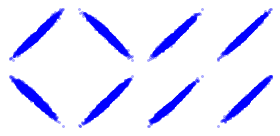

In [169]:
fig, axs = plt.subplots(2,4, figsize=(4,2))
for i in range(8):
    row = i // 4
    col = i % 4
    ax = axs[row,col]
    ax.scatter(B[:,i], A[:,i], s=4, color='b', alpha=0.25)
    ax.axis('off')
#     ax.set_xlabel('Ground truth latent')
#     ax.set_ylabel('Estimated latent')
#     ax.grid('..')
fig.tight_layout()

In [153]:
import numpy as numx

def calculate_amari_distance(matrix_one,
                             matrix_two,
                             version=1):
    """ Calculate the Amari distance between two input matrices.
    :param matrix_one: the first matrix
    :type matrix_one: numpy array
    :param matrix_two: the second matrix
    :type matrix_two: numpy array
    :param version: Variant to use.
    :type version: int
    :return: The amari distance between two input matrices.
    :rtype: float
    """
    if matrix_one.shape != matrix_two.shape:
        return "Two matrices must have the same shape."
    product_matrix = numx.abs(numx.dot(matrix_one,
                                       numx.linalg.inv(matrix_two)))

    product_matrix_max_col = numx.array(product_matrix.max(0))
    product_matrix_max_row = numx.array(product_matrix.max(1))

    n = product_matrix.shape[0]

    """ Formula from ESLII
    Here they refered to as "amari error"
    The value is in [0, N-1].
    reference:
        Bach, F. R.; Jordan, M. I. Kernel Independent Component
        Analysis, J MACH LEARN RES, 2002, 3, 1--48
    """
    amari_distance = product_matrix / numx.tile(product_matrix_max_col, (n, 1))
    amari_distance += product_matrix / numx.tile(product_matrix_max_row, (n, 1)).T
    amari_distance = amari_distance.sum() / (2 * n) - 1
    amari_distance = amari_distance / (n-1)
    return amari_distance

In [154]:
print("Amari distance for B1:", calculate_amari_distance(B1, BB1))
print("Amari distance for B2:", calculate_amari_distance(B2, BB2))

Amari distance for B1: 0.16492316394918433
Amari distance for B2: 0.352378050478662
